In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import umap
import os

from umap_utils import add_dummy_var_df, get_neural_explainability, get_common_models, plot_embedding_task_all, plot_embedding_task_all_ev, refactor_ev_matrix

import sys
sys.path.append('../code')
from path_utils import PATH_TO_RESULTS

In [2]:
%load_ext autoreload
%autoreload 2

#### Load the results

In [3]:
exp_condition = 'active'

In [4]:
res_df = pd.read_hdf(os.path.join(PATH_TO_RESULTS,'task_driven_results_'+exp_condition+'.h5'), 'df')  
res_df_0 = pd.read_hdf(os.path.join(PATH_TO_RESULTS,'untrained_results_'+exp_condition+'.h5'), 'df')

save_flag = False
PATH_TO_FIG = None

In [5]:
res_df_0['model_task'] = 'random'
res_df_0['model_train_acc'] = 1
res_df_0['model_test_acc'] = 1
res_df_0['model_val_acc'] = 1

res_df = pd.concat([res_df,res_df_0])

In [6]:
model_type_list = ['spatial_temporal', 'temporal_spatial', 'spatiotemporal']

res_df_tmp = res_df[res_df.arch_type.isin(model_type_list)].copy()
res_df_tmp, all_test_name_list, all_layer_type_list = add_dummy_var_df(res_df_tmp)

In [7]:
ev = get_neural_explainability(res_df_tmp, all_layer_type_list)

In [8]:
model_task_list = ['classification','torque', 'regression','regress_ee_vel','regress_ee_pos_vel', 'regress_ee_pos_vel_acc',\
    'regress_ee_elbow_pos', 'regress_ee_elbow_vel', 'regress_ee_elbow_pos_vel', 'regress_ee_elbow_pos_vel_acc', \
    'regress_joints_pos', 'regress_joints_vel', 'regress_joints_pos_vel', 'regress_joints_pos_vel_acc','bt', 'autoencoder', 'random']

In [9]:
ev_tmp = ev.groupby(['model_task','monkey','arch_type','model_name'],as_index = False).mean()

In [10]:
ev_tmp = get_common_models(ev_tmp,model_task_list)

In [11]:
layer_list = ['model_layer','model_max_layer']
arch_param_list = ['layer_t_stride', 'layer_s_stride', 't_kernelsize', 's_kernelsize', 'n_tkernels', 'n_skernels']
layer_type_list = ['layer_type_temporal','layer_type_spatial','layer_type_spatiotemporal']
task_list = ['autoencoder', 'bt', 'classification', 'regress_ee_elbow_pos', 'regress_ee_elbow_pos_vel', 'regress_ee_elbow_pos_vel_acc', 'regress_ee_elbow_vel', \
            'regress_ee_pos_vel', 'regress_ee_pos_vel_acc', 'regress_ee_vel', 'regress_joints_pos', 'regress_joints_pos_vel', 'regress_joints_vel', 'regress_joints_pos_vel_acc', 'regression', 'torque', 'random']
arch_type_list = ['spatial_temporal', 'temporal_spatial', 'spatiotemporal']
monkey_list = ['Butter', 'Chips', 'Han', 'Lando', 'S1Lando', 'Snap']
model_test_list = [ 'model_test_autoencoder', 'model_test_bt', 'model_test_classification', 'model_test_regress_ee_elbow_pos', 'model_test_regress_ee_elbow_pos_vel', \
                'model_test_regress_ee_elbow_pos_vel_acc', 'model_test_regress_ee_elbow_vel', 'model_test_regress_ee_pos_vel', 'model_test_regress_ee_pos_vel_acc', \
                'model_test_regress_ee_vel', 'model_test_regress_joints_pos', 'model_test_regress_joints_pos_vel', 'model_test_regress_joints_pos_vel_acc', 'model_test_regress_joints_vel', \
                    'model_test_regression', 'model_test_torque', 'model_test_random']

In [12]:
#### Create dataframe with all EV per each task
ev_tmp_all = pd.DataFrame()
all_ev_list = []
for model_task_tmp in model_task_list:
    model_task_list_wo_1 = model_task_list.copy()
    ev_tmp_all_now = ev_tmp[ev_tmp.model_task == model_task_tmp].copy()
    for model_task_tmp1 in model_task_list_wo_1:
        ev_name_tmp = 'ev_test_' + model_task_tmp1
        ev_tmp_all_now[ev_name_tmp] = list(np.array(ev_tmp[ev_tmp.model_task == model_task_tmp1].ev_test))
        all_ev_list.append(ev_name_tmp)
    ev_tmp_all = pd.concat([ev_tmp_all,ev_tmp_all_now])
all_ev_list = list(np.unique(all_ev_list))

In [13]:
ev_all_arch = ev_tmp_all[ev_tmp_all.model_task == 'autoencoder']

In [14]:
test_ev_list = ['ev_test_' + test_task_tmp for test_task_tmp in task_list]
test_ev_list = test_ev_list[:-1]
test_ev_list

['ev_test_autoencoder',
 'ev_test_bt',
 'ev_test_classification',
 'ev_test_regress_ee_elbow_pos',
 'ev_test_regress_ee_elbow_pos_vel',
 'ev_test_regress_ee_elbow_pos_vel_acc',
 'ev_test_regress_ee_elbow_vel',
 'ev_test_regress_ee_pos_vel',
 'ev_test_regress_ee_pos_vel_acc',
 'ev_test_regress_ee_vel',
 'ev_test_regress_joints_pos',
 'ev_test_regress_joints_pos_vel',
 'ev_test_regress_joints_vel',
 'ev_test_regress_joints_pos_vel_acc',
 'ev_test_regression',
 'ev_test_torque']

#### Refactor matrix EV

In [15]:
standardize_flag = True
batch_size = 73  ### Number of models per datapoint  (292 models x 16 tasks)

In [16]:
all_ev_refactor, n_batches = refactor_ev_matrix(ev_all_arch,test_ev_list,batch_size,standardize_flag)

In [17]:
reducer = umap.UMAP(random_state=42)
mapper = reducer.fit(all_ev_refactor)
embedding = mapper.transform(all_ev_refactor)

#### Plot UMAP

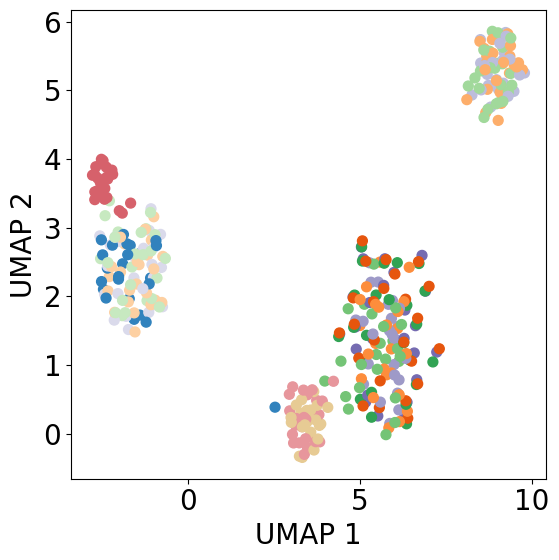

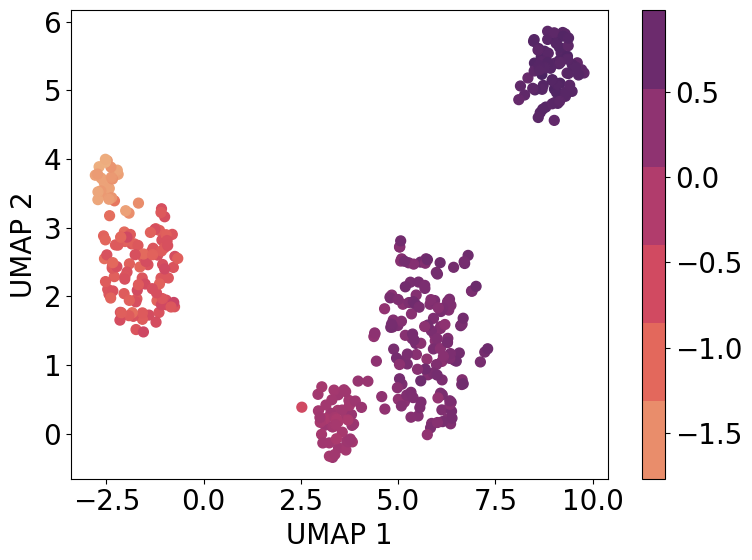

In [18]:
suffix_emb='umap'

task_list_tmp = task_list[:-1]

plot_embedding_task_all(embedding,n_batches,task_list_tmp,standardize_flag,save_flag,PATH_TO_FIG,suffix_emb=suffix_emb)

plot_embedding_task_all_ev(embedding,all_ev_refactor,standardize_flag,save_flag,PATH_TO_FIG,suffix_emb=suffix_emb)
plt.show()

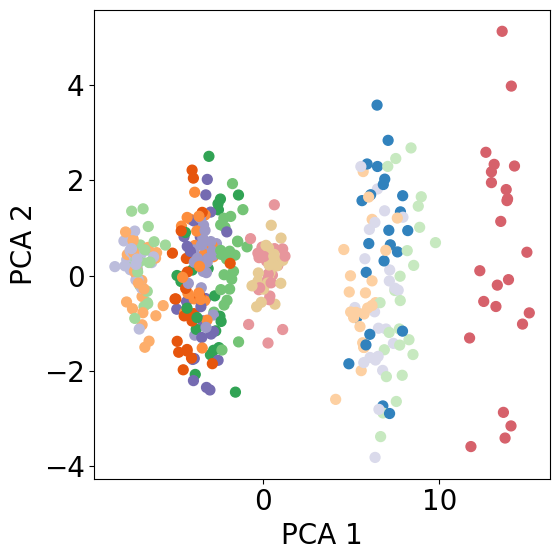

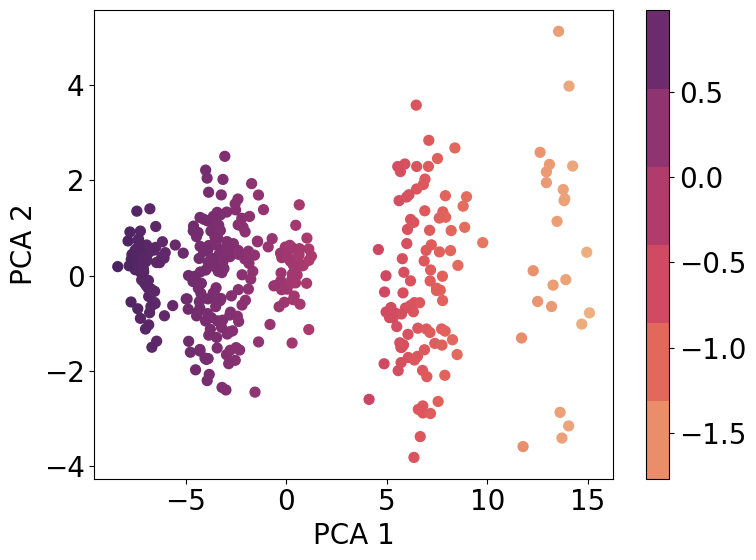

In [19]:
suffix_emb='pca'

reducer = PCA(n_components=2,random_state=42)
mapper = reducer.fit(all_ev_refactor)
embedding = mapper.transform(all_ev_refactor)

task_list_tmp = task_list[:-1]

plot_embedding_task_all(embedding,n_batches,task_list_tmp,standardize_flag,save_flag,PATH_TO_FIG,suffix_emb=suffix_emb)

plot_embedding_task_all_ev(embedding,all_ev_refactor,standardize_flag,save_flag,PATH_TO_FIG,suffix_emb=suffix_emb)
plt.show()